## Mini Proc Model with MiniAE to demonstrate the use of LTN in an Autoencoder
1. Generate the data
2. Train the Autoencoder
3. Modify the AE with LTN

## Mini Proc Model
### Process

e1 -> e2 -> e3 -> e4 -> e5

event attributes = name, user

event_names = ["Create SC", "Approve SC", "Create PO", "Approve PO", "Pay"]

user_names = ["Dev", "Chantal", "Seokju", "Jonas", "Kaly"]

### Valid traces
1. ["Create SC", "Approve SC", "Create PO", "Approve PO", "Pay"]
2. ~~["Create SC", "Create PO", "Approve SC", "Approve PO", "Pay"]~~ for now

### Event User Mapping
1. "Create SC" : "Dev", "Chantal" 
2. "Approve SC" : "Kaly"
3. "Create PO" : "Dev", "Jonas"
4. "Approve PO" : "Kaly"
5. "Pay" : "Seokju"

### Data
1. Traces = 1000
2. p_anomaly = 0.3 # This means that the possibility that a given trace is anomalous is 0.3
3. Anomaly types:
    1. Control flow: irregular flow ordering
    2. Attribute: Wrong attributes assigned

In [44]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from pprint import pprint
import may
import itertools
import pickle

np.random.seed(0)

In [45]:
import tensorflow as tf
from tensorflow import keras
import ltn
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU found")
    print("Memory growth set")
else:
    print("No GPU found")
from tensorflow.keras.layers import Input, Dense, Dropout, GaussianNoise, Reshape, Flatten, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from typing import Union
import ltn

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU found
Memory growth set


In [46]:
synth_dataset = may.Dataset(max_cases=5000, anomaly_probabilty=0.3)
synth_dataset.create_dataset()
print(f"Cases Distribution: {synth_dataset.actual_cases}")
one_hot_flat = synth_dataset.one_hot_encoded_features
print(f"one_hot_flat shape: {one_hot_flat.shape}")
print(f"Raw features test:\n{synth_dataset.raw_dataset_as_df[:5]}")
print(f"Encoded Features test:\n{synth_dataset.encoded_features[0]}")
# pprint(f"One hot Encoded feature test: {one_hot_flat[0]}")
print(f"De encoding test:\n{synth_dataset.inverse_one_hot_encoded_features_to_int(one_hot_flat[0])}")
# from pprint import pprint
# pprint(f"Encoded Features: {temp.shape}")
# temp = synth_dataset.one_hot_encoded_features
# pprint(f"One hot Encoded Features: {temp.shape}")
# int_de_encode = synth_dataset.inverse_one_hot_encoded_features_to_int(temp[0])
# print(f"De encoding test: {int_de_encode}")
# str_de_encode = synth_dataset.inverse_one_hot_encoded_features_to_string(temp[0])

encoders[name]:
[('Approve PO', '0'), ('Approve SC', '1'), ('Create PO', '2'), ('Create SC', '3'), ('Pay', '4')]
encoders[user]:
[('Chantal', '0'), ('Dev', '1'), ('Jonas', '2'), ('Kaly', '3'), ('Seokju', '4')]
Cases Distribution: [3500, 748, 750]
one_hot_flat shape: (4998, 50)
Raw features test:
         name    user  case_id
0   Create SC     Dev        0
1  Approve SC    Kaly        0
2   Create PO   Jonas        0
3  Approve PO    Kaly        0
4         Pay  Seokju        0
Encoded Features test:
[3 1 1 3 2 2 0 3 4 4]
De encoding test:
[[3 1 1 3 2 2 0 3 4 4]]


In [47]:
class BIGDAE():
    """
    A class container to hold the DAE model outputs with a shared latent space
    The Class contains each output as a separate model and a shared latent space model
    Each output is later converted to a LTN Predicate
    """
    def __init__(self, dataset: may.Dataset, hidden_layers:int=2, hidden_size_factor:Union[float, list]=0.2, noise:bool=True):
        self.dataset = dataset
        self.model = None # Main model which will be trained on one hot encoded features of dataset
        self.input_layer = None # keras input layer of the model
        self.latent_space_last_layer = None # shared latent space/decoder layer of the models 
        self.individual_outputs = [] # individual outputs of the model
        self.output_layer = [] # Single output of the model 
        self.individual_models = [] # models for each output, which have shared input and latent spcae layers
        self.ltn_predicates = [] # LTN predicates for each output
        self.history = None # training history of the model
        
        # Parameters
        self.hidden_layers = hidden_layers # 2
        self.hidden_size_factor = hidden_size_factor # 0.2
        self.noise = noise # for denoising autoencoder
        self.input_shape = self.dataset.one_hot_encoded_features_2d.shape[1:]
        # print(f"self.input_shape: {self.input_shape}")        
        pass
    
    def _build_main_model(self):
        
        # Layers
        self.input_layer = Input(shape=(*self.input_shape, ), name='input')
        self.flat_input = Flatten(name="flatten")(self.input_layer)
        
        # Noise layer
        if self.noise is not None:
            x = GaussianNoise(self.noise, name="noise")(self.flat_input)

        # Hidden layers
        for i in range(self.hidden_layers):
            if isinstance(self.hidden_size_factor, list):
                factor = self.hidden_size_factor[i]
            else:
                factor = self.hidden_size_factor
            x = Dense(int(self.input_shape[0] * self.input_shape[1] * factor), activation='elu', name=f'hidden-{i}')(x)
            x = Dropout(0.5, name=f'dropout-{i}')(x)

        # latent space
        self.latent_space_last_layer = x

        # Output layer(s)
        self.individual_outputs = []
        for i in range(self.input_shape[0]):
            name = f"event-{i//2}" if i%2==0 else f"user-{i//2}"
            output = Dense(self.input_shape[1], activation='sigmoid', name=name)(self.latent_space_last_layer)
            self.individual_outputs.append(output)

        self.output_layer = Concatenate(axis=1, name="concatenate")(self.individual_outputs)
        self.output_layer = Reshape((self.input_shape[0], self.input_shape[1]), name="output-layer-reshape")(self.output_layer)
        
        # Build model
        self.model = Model(inputs=self.input_layer, outputs=self.output_layer, name="main-DAE")
        # self.model._name = "Main DAE"
        pass
    
    def _compile_main_model(self):
        # Compile model
        self.model.compile(
            optimizer=Adam(learning_rate=0.0001, beta_2=0.99),
            loss='mean_squared_error',
            metrics=['accuracy']
        )
        pass
    
    def _build_individual_models(self):
        # Build individual models
        self.individual_models = []
        for individual_output in self.individual_outputs:
            name = f"individual-{individual_output.name}".split(r"/")[0]
            individual_model = Model(inputs=self.input_layer, outputs=individual_output, name=name)
            # individual_model._name = f"Individual {individual_output.name}"
            self.individual_models.append(individual_model)
        pass
    
    
    def _compile_individual_models(self):
        # Compile individual models
        for individual_model in self.individual_models:
            individual_model.compile(
                optimizer=Adam(learning_rate=0.00001, beta_2=0.99),
                loss='mean_squared_error',
            )
        pass
    
    def build(self):
        self._build_main_model()
        self._compile_main_model()
        self._build_individual_models()
        self._compile_individual_models()
        pass
    
    def fit(self, epochs:int=150, batch_size:int=500, validation_split:float=0.2, verbose:int=1):
        self.history = self.model.fit(
            self.dataset.one_hot_encoded_features_2d, self.dataset.one_hot_encoded_features_2d,
            epochs=epochs,
            batch_size=batch_size,
            shuffle=True,
            validation_split=validation_split,
            verbose=verbose,
        )
        pd.DataFrame(self.history.history).plot(figsize=(8,5))
        plt.show()
    
    def predict(self, test_vector):
        return self.model.predict(test_vector)
    
    def _summary_main_model(self):
        print("Printing Main Model Summary")
        self.model.summary()
        pass
    
    def _summary_individual_models(self):
        print("Printing Individual Models Summary")
        for individual_model in self.individual_models:
            individual_model.summary()
        pass
    
    def save_pickle(self):
        with open("daemodel.pkl", "wb") as fp:
            pickle.dump(self, fp, protocol=-1)
    
    def summary(self):
        self._summary_main_model()
        self._summary_individual_models()
        pass
        
        

In [48]:
main_model = BIGDAE(synth_dataset)
main_model.build()

Epoch 1/150
8/8 [==============================] - 1s 33ms/step - loss: 0.3369 - accuracy: 0.1660 - val_loss: 0.2690 - val_accuracy: 0.2057
Epoch 2/150
8/8 [==============================] - 0s 15ms/step - loss: 0.3365 - accuracy: 0.1688 - val_loss: 0.2682 - val_accuracy: 0.2048
Epoch 3/150
8/8 [==============================] - 0s 15ms/step - loss: 0.3360 - accuracy: 0.1673 - val_loss: 0.2674 - val_accuracy: 0.2058
Epoch 4/150
8/8 [==============================] - 0s 16ms/step - loss: 0.3351 - accuracy: 0.1663 - val_loss: 0.2666 - val_accuracy: 0.2059
Epoch 5/150
8/8 [==============================] - 0s 16ms/step - loss: 0.3315 - accuracy: 0.1715 - val_loss: 0.2658 - val_accuracy: 0.2064
Epoch 6/150
8/8 [==============================] - 0s 16ms/step - loss: 0.3302 - accuracy: 0.1715 - val_loss: 0.2651 - val_accuracy: 0.2071
Epoch 7/150
8/8 [==============================] - 0s 16ms/step - loss: 0.3305 - accuracy: 0.1713 - val_loss: 0.2644 - val_accuracy: 0.2069
Epoch 8/150
8/8 [===

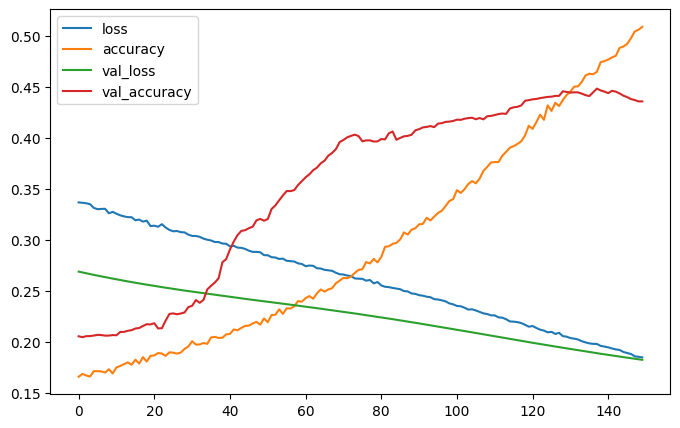

In [49]:
main_model.fit()

In [50]:
test_vector_2d = synth_dataset.one_hot_encoded_features_2d[4000].reshape(-1, 10, 5)
pprint(test_vector_2d)
op = main_model.predict(test_vector_2d)
pprint(op)

array([[[0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.]]])
1/1 [==============================] - 0s 87ms/step
array([[[0.38460997, 0.29035357, 0.2506785 , 0.7457175 , 0.26725346],
        [0.43871564, 0.40687272, 0.23749983, 0.38995233, 0.26385865],
        [0.30917957, 0.65456647, 0.42088553, 0.17833388, 0.23570825],
        [0.52341884, 0.20529298, 0.37081748, 0.4524339 , 0.3356011 ],
        [0.2551488 , 0.3694667 , 0.35027486, 0.5643409 , 0.26177597],
        [0.29721436, 0.55294245, 0.5039105 , 0.44205076, 0.36996034],
        [0.6839553 , 0.3268577 , 0.36913538, 0.44155383, 0.21305232],
        [0.2641276 , 0.30181366, 0.2581003 , 0.69357425, 0.5756286 ],
        [0.41300625, 0.25670555, 0.30336288, 0.4543477 , 0.7634484 ],
        [0.11859

In [51]:
first_event_prediction = main_model.individual_models[0].predict(test_vector_2d)
pprint(first_event_prediction)

1/1 [==============================] - 0s 51ms/step
array([[0.38460997, 0.29035357, 0.2506785 , 0.7457175 , 0.26725346]],
      dtype=float32)


In [52]:
x_one_hot_2d, y_int = synth_dataset.x_one_hot_2d_y_int
x_one_hot_2d = x_one_hot_2d.reshape(-1, 10, 5)
print(x_one_hot_2d.shape, y_int.shape)


(4998, 10, 5) (4998, 10)


In [53]:
permuted_indices = np.random.permutation(x_one_hot_2d.shape[0])
x_one_hot_2d = x_one_hot_2d[permuted_indices]
y_int = y_int[permuted_indices]
split_point = int(one_hot_flat.shape[0] * 0.8 )
x_one_hot_2d_train = x_one_hot_2d[:split_point]
x_one_hot_2d_test = x_one_hot_2d[split_point:]
y_int_train = y_int[:split_point]
y_int_test = y_int[split_point:]

print(f"x_one_hot_2d_train.shape: {x_one_hot_2d_train.shape}")
print(f"x_one_hot_2d_test.shape: {x_one_hot_2d_test.shape}")
print(f"y_int_train.shape: {y_int_train.shape}")
print(f"y_int_test.shape: {y_int_test.shape}")

x_one_hot_2d_train.shape: (3998, 10, 5)
x_one_hot_2d_test.shape: (1000, 10, 5)
y_int_train.shape: (3998, 10)
y_int_test.shape: (1000, 10)


In [54]:
x_one_hot_2d_train[0]

array([[0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

In [55]:
batch_size = 500
ds_train = tf.data.Dataset.from_tensor_slices((x_one_hot_2d_train,y_int_train)).batch(batch_size)
ds_test = tf.data.Dataset.from_tensor_slices((x_one_hot_2d_test,y_int_test)).batch(batch_size)

## Defining LTN Predicates

### Encodings

encoders[name]:

[('Approve PO', '0'), ('Approve SC', '1'), ('Create PO', '2'), ('Create SC', '3'), ('Pay', '4')]

encoders[user]:

[('Chantal', '0'), ('Dev', '1'), ('Jonas', '2'), ('Kaly', '3'), ('Seokju', '4')]


In [56]:
# Sequencial predicates
event_predicates = []
user_predicates = []
for i in range(0, 10, 2):
    event_predicates.append(ltn.Predicate.FromLogits(main_model.individual_models[i], activation_function="softmax", with_class_indexing=True))
for i in range(1, 10, 2):
    user_predicates.append(ltn.Predicate.FromLogits(main_model.individual_models[i], activation_function="softmax", with_class_indexing=True))
    
# order taken from the label encoder 
event_approve_po = ltn.Constant(0, trainable=False)
event_approve_sc = ltn.Constant(1, trainable=False)
event_create_po = ltn.Constant(2, trainable=False)
event_create_sc = ltn.Constant(3, trainable=False)
event_pay = ltn.Constant(4, trainable=False)

user_chantal = ltn.Constant(0, trainable=False)
user_dev = ltn.Constant(1, trainable=False)
user_jonas = ltn.Constant(2, trainable=False)
user_kaly = ltn.Constant(3, trainable=False)
user_seokju = ltn.Constant(4, trainable=False)

event_encoded_list = [event_approve_po, event_approve_sc, event_create_po, event_create_sc,  event_pay]
event_sequencial_list = [event_create_sc, event_approve_sc, event_create_po, event_approve_po, event_pay]
user_encoded_list = [user_chantal, user_dev, user_jonas, user_kaly, user_seokju]
user_encoded_set = set(user_encoded_list)

In [57]:
Not = ltn.Wrapper_Connective(ltn.fuzzy_ops.Not_Std())
And = ltn.Wrapper_Connective(ltn.fuzzy_ops.And_Prod())
Or = ltn.Wrapper_Connective(ltn.fuzzy_ops.Or_ProbSum())
Implies = ltn.Wrapper_Connective(ltn.fuzzy_ops.Implies_Reichenbach())
Forall = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMeanError(p=2),semantics="forall")


### Valid traces
1. ["Create SC", "Approve SC", "Create PO", "Approve PO", "Pay"]
2. ~~["Create SC", "Create PO", "Approve SC", "Approve PO", "Pay"]~~ for now

### Event User Mapping
1. "Create SC" : "Dev", "Chantal" 
2. "Approve SC" : "Kaly"
3. "Create PO" : "Dev", "Jonas"
4. "Approve PO" : "Kaly"
5. "Pay" : "Seokju"

In [61]:
formula_aggregator = ltn.Wrapper_Formula_Aggregator(ltn.fuzzy_ops.Aggreg_pMeanError(p=2))

@tf.function
def axioms(features, labels, training=False):
    traces = ltn.Variable("traces",features)
    
    axioms = [
        Forall(traces, event_predicates[0]([traces, event_create_sc], training=training)),
        Forall(traces, user_predicates[0]([traces, user_dev], training=training)),
        Forall(traces, user_predicates[0]([traces, user_chantal], training=training)),
        
        Forall(traces, event_predicates[1]([traces, event_approve_sc], training=training)),
        Forall(traces, user_predicates[1]([traces, user_kaly], training=training)),
        
        Forall(traces, event_predicates[2]([traces, event_create_po], training=training)),
        Forall(traces, user_predicates[2]([traces, user_dev], training=training)),
        Forall(traces, user_predicates[2]([traces, user_jonas], training=training)),
        
        Forall(traces, event_predicates[3]([traces, event_approve_po], training=training)),
        Forall(traces, user_predicates[3]([traces, user_kaly], training=training)),
        
        Forall(traces, event_predicates[4]([traces, event_pay], training=training)),
        Forall(traces, user_predicates[4]([traces, user_seokju], training=training))
        
    ]
    
    # TODO: Write the exclusion axioms
    
    # User Mutual exclusion
    user_sets = [{user_dev, user_chantal}, {user_kaly}, {user_dev, user_jonas}, {user_kaly}, {user_seokju}]
    for i, user_set in enumerate(user_sets):
        non_users = list(user_encoded_set-user_set)
        for non_user in non_users:
            axioms.append(Forall(traces, Not(user_predicates[i]([traces, non_user], training=training))))
    
    
    # Event Mutual exclusion
    for i in range(len(event_predicates)):
        for j, non_event in enumerate(event_sequencial_list):
            if i != j:
                not_axiom = Forall(traces, Not(event_predicates[i]([traces, non_event], training=training)))
                axioms.append(not_axiom)
    
    
    sat_level = formula_aggregator(axioms).tensor
    return sat_level

In [62]:
for features, labels in ds_test:
    print("Initial sat level %.5f"%axioms(features,labels))
    

Initial sat level 0.59717
Initial sat level 0.59697


In [63]:
metrics_dict = {
    'train_sat_kb': tf.keras.metrics.Mean(name='train_sat_kb'),
    'test_sat_kb': tf.keras.metrics.Mean(name='test_sat_kb')
}

In [64]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_2=0.99)
@tf.function
def train_step(features, labels):
    # sat and update
    trainable_variables_events = [event_predicate.trainable_variables for event_predicate in event_predicates]
    trainable_variables_events = list(itertools.chain.from_iterable(trainable_variables_events))
    trainable_variables_users = [user_predicate.trainable_variables for user_predicate in user_predicates]
    trainable_variables_users = list(itertools.chain.from_iterable(trainable_variables_users))
    trainable_variables = trainable_variables_events + trainable_variables_users
    with tf.GradientTape() as tape:
        sat = axioms(features, labels, training=True)
        loss = 1.-sat
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))
    sat = axioms(features, labels) # compute sat without dropout
    metrics_dict['train_sat_kb'](sat)
    
@tf.function
def test_step(features, labels):
    # sat
    sat = axioms(features, labels)
    metrics_dict['test_sat_kb'](sat)

In [65]:
from collections import defaultdict

def train(
        epochs,
        metrics_dict, 
        ds_train, 
        ds_test, 
        train_step, 
        test_step,
        track_metrics=10,
        csv_path=None,
        scheduled_parameters=defaultdict(lambda : {})
    ):
    """
    Args:
        epochs: int, number of training epochs.
        metrics_dict: dict, {"metrics_label": tf.keras.metrics instance}.
        ds_train: iterable dataset, e.g. using tf.data.Dataset.
        ds_test: iterable dataset, e.g. using tf.data.Dataset.
        train_step: callable function. the arguments passed to the function
            are the itered elements of ds_train.
        test_step: callable function. the arguments passed to the function
            are the itered elements of ds_test.
        csv_path: (optional) path to create a csv file, to save the metrics.
        scheduled_parameters: (optional) a dictionary that returns kwargs for
            the train_step and test_step functions, for each epoch.
            Call using scheduled_parameters[epoch].
    """
    template = "Epoch {}"
    for metrics_label in metrics_dict.keys():
        template += ", %s: {:.4f}" % metrics_label
    if csv_path is not None:
        csv_file = open(csv_path,"w+")
        headers = ",".join(["Epoch"]+list(metrics_dict.keys()))
        csv_template = ",".join(["{}" for _ in range(len(metrics_dict)+1)])
        csv_file.write(headers+"\n")
    
    for epoch in range(epochs):
        for metrics in metrics_dict.values():
            metrics.reset_states()

        for batch_elements in ds_train:
            train_step(*batch_elements,**scheduled_parameters[epoch])
        for batch_elements in ds_test:
            test_step(*batch_elements,**scheduled_parameters[epoch])

        metrics_results = [metrics.result() for metrics in metrics_dict.values()]
        if epoch%track_metrics == 0:
            print(template.format(epoch,*metrics_results))
        if csv_path is not None:
            csv_file.write(csv_template.format(epoch,*metrics_results)+"\n")
            csv_file.flush()
    if csv_path is not None:
        csv_file.close()

In [66]:
train(
    500,
    metrics_dict,
    ds_train,
    ds_test,
    train_step,
    test_step,
    csv_path=None,
    track_metrics=50 #at which epoch
)

Epoch 0, train_sat_kb: 0.6076, test_sat_kb: 0.6117
Epoch 50, train_sat_kb: 0.6692, test_sat_kb: 0.6692
Epoch 100, train_sat_kb: 0.6692, test_sat_kb: 0.6692
Epoch 150, train_sat_kb: 0.6692, test_sat_kb: 0.6692
Epoch 200, train_sat_kb: 0.6692, test_sat_kb: 0.6692
Epoch 250, train_sat_kb: 0.6692, test_sat_kb: 0.6692
Epoch 300, train_sat_kb: 0.6692, test_sat_kb: 0.6692
Epoch 350, train_sat_kb: 0.6692, test_sat_kb: 0.6692
Epoch 400, train_sat_kb: 0.6692, test_sat_kb: 0.6692
Epoch 450, train_sat_kb: 0.6692, test_sat_kb: 0.6692


In [68]:
print(test_vector_2d)
print(main_model.predict(test_vector_2d))
print(main_model.individual_models[0].predict(test_vector_2d))

[[[0. 0. 0. 1. 0.]
  [0. 1. 0. 0. 0.]
  [0. 1. 0. 0. 0.]
  [0. 0. 0. 1. 0.]
  [0. 0. 1. 0. 0.]
  [0. 0. 1. 0. 0.]
  [0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 1.]
  [1. 0. 0. 0. 0.]
  [0. 0. 0. 1. 0.]]]
1/1 [==============================] - 0s 22ms/step
[[[0. 0. 0. 1. 0.]
  [1. 1. 0. 0. 0.]
  [0. 1. 0. 0. 0.]
  [0. 0. 0. 1. 0.]
  [0. 0. 1. 0. 0.]
  [0. 1. 1. 0. 0.]
  [1. 0. 0. 0. 0.]
  [0. 0. 0. 1. 0.]
  [0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 1.]]]
1/1 [==============================] - 0s 21ms/step
[[0. 0. 0. 1. 0.]]
